<a href="https://colab.research.google.com/github/spdin/cnn-fashion-mnist/blob/master/CNN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library and Dataloading






In [0]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

import os

show = ToPILImage()

import numpy as np
import matplotlib.pyplot as plt

batchSize = 64

#transform = transforms.Compose([transforms.Resize(224),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5,), (0.5,)),])

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=0)

cuda


## How to combine/concatenating the Data Loader

In [0]:
combine = torch.utils.data.ConcatDataset([trainset,testset])

combineloader = torch.utils.data.DataLoader(combine, batch_size=batchSize, shuffle=False, num_workers=0)

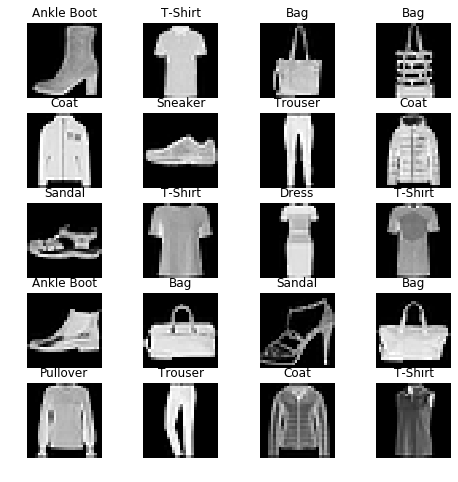

In [0]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

fig = plt.figure(figsize=(8,8));

columns = 4;
rows = 5;

for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(trainset));
    img = trainset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[trainset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    
plt.show()

In the following part, training will using CUDA



In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
def run_model(net, loader, criterion, optimizer, train = True):
    running_loss = 0
    running_accuracy = 0

    # Set mode
    if train:
        net.train()
    else:
        net.eval()

    for i, (X, y) in enumerate(loader):
        # Pass to gpu or cpu
        X, y = X.to(device), y.to(device)
        
        print(X.size())

        # Zero the gradient
        optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            output = net(X)
            _, pred = torch.max(output, 1)
            loss = criterion(output, y)

        # If on train backpropagate
        if train:
            loss.backward()
            optimizer.step()

            
        # Calculate stats
        running_loss += loss.item()
        running_accuracy += torch.sum(pred == y.detach())
        
    return running_loss / len(loader), running_accuracy.double() / len(loader.dataset)

In [0]:
def run_training(net, criterion, optimizer, start_epoch, nepochs):
  
  #nepochs = 10
  #learning_rate = 0.005
  
  time_total = 0
  
  train_loss_list = []
  train_acc_list = []
  val_loss_list = []
  val_acc_list = []
  
  # get class name in string
  model_str = net.__class__.__name__

  dirName = model_str
  try:
    # Create target Directory
    os.mkdir(dirName)
  except FileExistsError:
    print("")

  for e in range(start_epoch, nepochs + 1):
    start = time.time()

    train_loss, train_acc = run_model(net, trainloader, criterion, optimizer)

    val_loss, val_acc = run_model(net, testloader, criterion, optimizer, False)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    end = time.time()
    
    time_process = end - start
    
    time_total = time_total + time_process

    # print stats
    stats = """Epoch: {}\t 
          train loss: {:.3f}, train acc: {:.3f}\t
          val loss: {:.3f}, val acc: {:.3f}\t
          time: {:.1f}s Total time: {:.1f}s""".format(e, train_loss, train_acc, val_loss, val_acc, time_process, time_total)
    
    print(stats)
    
    # save weight per epoch
    PATH = './' + model_str + '/'+ model_str +'_' + str(e) + '.pth'
    
    PATH_data = './' + model_str + '/'+ model_str + '_data_' + str(e) + '.pth'
    
    #torch.save(net.state_dict(), PATH)
    #PATH = './' + model_str + '/'+ model_str +'_' + str(e + 1) + '.pth'
    
    torch.save({
            'epoch': e,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc}, PATH)
    
    torch.save({
            'epoch': e,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc}, PATH_data)
    
  nepoch_list = list(range(1, len(train_loss_list)+1))
  import matplotlib.ticker as mticker

  plt.figure()
  plt.xlabel('N Epoch')
  plt.title('Data Plot Losses')
  plt.ylabel('Losses')
  plt.ticklabel_format(style='plain', axis='x', useOffset=True)
  plt.plot(nepoch_list, train_loss_list,label = "Train losses")
  plt.plot(nepoch_list, val_loss_list, label = "Test losses")
  plt.legend()

  plt.figure()
  plt.xlabel('N Epoch')
  plt.title('Data Plot Accuracy')
  plt.ylabel('Accuracy')
  plt.ticklabel_format(style='plain', axis='x', useOffset=True)
  plt.plot(nepoch_list, train_acc_list, label = "Train accuracy")
  plt.plot(nepoch_list, val_acc_list, label = "Test accuracy")
  plt.legend()

 

# MLP

In [0]:
batchSize = 256

nworkers = 4

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=nworkers)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=nworkers)

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128,64)
        self.l4 = nn.Linear(64,10)
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.log_softmax(self.l4(x), dim=1)
        return x

In [0]:
net = MLP().to(device);
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)

start_epoch = 1
nepochs = 100

run_training(net, criterion, optimizer, start_epoch, nepochs)

Epoch: 1	 
          train loss: 1.046, train acc: 0.626	
          val loss: 0.572, val acc: 0.787	
          time: 7.6s Total time: 7.6s
Epoch: 2	 
          train loss: 0.508, train acc: 0.816	
          val loss: 0.476, val acc: 0.823	
          time: 7.6s Total time: 15.3s
Epoch: 3	 
          train loss: 0.435, train acc: 0.843	
          val loss: 0.466, val acc: 0.828	
          time: 7.7s Total time: 22.9s


KeyboardInterrupt: ignored

In [0]:
val_loss, val_acc = run_model(net, testloader, criterion, optimizer, False)

print(val_acc)

torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 28, 28])
torch.Size([25

## MLP with Relu

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128,64)
        self.l4 = nn.Linear(64,10)
    def forward(self,x):
        
        x = x.view(x.shape[0],-1)
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        #x = F.log_softmax(self.l4(x), dim=1)
        return x

Epoch: 1	 
          train loss: 1.499, train acc: 0.505	
          val loss: 1.116, val acc: 0.634	
          time: 7.5s Total time: 7.5s
Epoch: 2	 
          train loss: 1.044, train acc: 0.644	
          val loss: 0.982, val acc: 0.671	
          time: 8.5s Total time: 15.9s
Epoch: 3	 
          train loss: 0.876, train acc: 0.695	
          val loss: 0.866, val acc: 0.693	
          time: 8.4s Total time: 24.4s
Epoch: 4	 
          train loss: 0.743, train acc: 0.732	
          val loss: 0.652, val acc: 0.760	
          time: 8.4s Total time: 32.7s
Epoch: 5	 
          train loss: 0.587, train acc: 0.778	
          val loss: 0.623, val acc: 0.766	
          time: 8.3s Total time: 41.0s
Epoch: 6	 
          train loss: 0.560, train acc: 0.786	
          val loss: 0.610, val acc: 0.778	
          time: 8.4s Total time: 49.4s
Epoch: 7	 
          train loss: 0.540, train acc: 0.793	
          val loss: 0.586, val acc: 0.776	
          time: 8.4s Total time: 57.8s
Epoch: 8	 
          

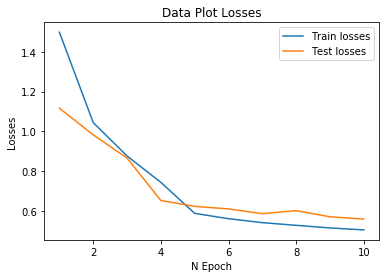

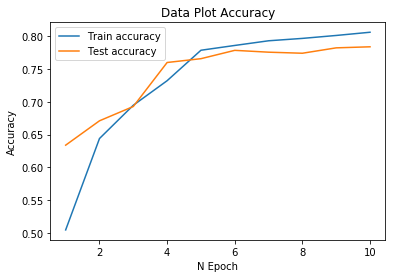

In [0]:
net = MLP().to(device);
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)

start_epoch = 1
nepochs = 10

run_training(net, criterion, optimizer, start_epoch, nepochs)

torch.Size([1, 28, 28])
2
2
tensor([[-7.7247e+00, -8.0841e+00, -8.2035e-03, -8.2900e+00, -5.7391e+00,
         -9.2596e+00, -5.5636e+00, -1.8495e+01, -1.0825e+01, -1.4133e+01]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
predicted : Pullover
actual : Pullover


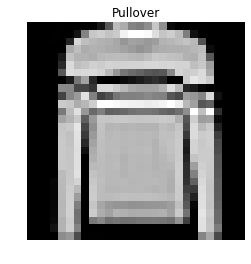

In [0]:
n = 5

X = trainset[n][0]
y = trainset[n][1]

print(X.size())

X = X.to(device)

X = X.unsqueeze(0)

print(X.size())

output = net(X)
_, pred = torch.max(output, 1)

print(pred.item())
print(y)

print(output)

img = trainset[n][0][0,:,:]

plt.title(labels_map[trainset[n][1]])
plt.axis('off')
plt.imshow(img, cmap='gray')

print("predicted : %s"%(labels_map[pred.item()]))
print("actual : %s"%(labels_map[y]))

2
2
tensor([[-8.1456e+00, -1.1631e+01, -1.2245e-03, -1.1681e+01, -7.8470e+00,
         -1.4142e+01, -7.5600e+00, -1.7363e+01, -1.3465e+01, -1.2712e+01]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)
predicted : Pullover
actual : Pullover


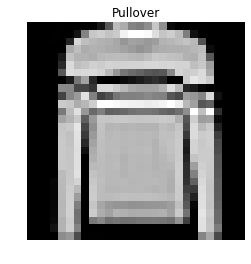

In [0]:
n = 5

X = trainset[n][0]
y = trainset[n][1]

X = X.to(device)


output = net(X)
_, pred = torch.max(output, 1)

print(pred.item())
print(y)

print(output)

img = trainset[n][0][0,:,:]

plt.title(labels_map[trainset[n][1]])
plt.axis('off')
plt.imshow(img, cmap='gray')

print("predicted : %s"%(labels_map[pred.item()]))
print("actual : %s"%(labels_map[y]))

In [0]:
output

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<ReluBackward0>)

## Continue training...


Epoch: 4	 
          train loss: 0.332, train acc: 0.878	
          val loss: 0.372, val acc: 0.866	
          time: 9.7s Total time: 9.7s
Epoch: 5	 
          train loss: 0.309, train acc: 0.886	
          val loss: 0.343, val acc: 0.876	
          time: 9.5s Total time: 19.2s
Epoch: 6	 
          train loss: 0.291, train acc: 0.892	
          val loss: 0.363, val acc: 0.873	
          time: 9.5s Total time: 28.7s


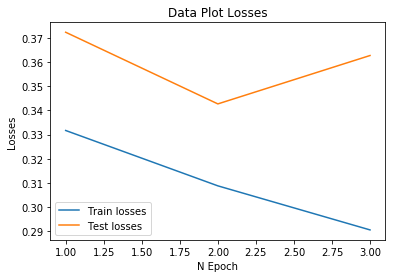

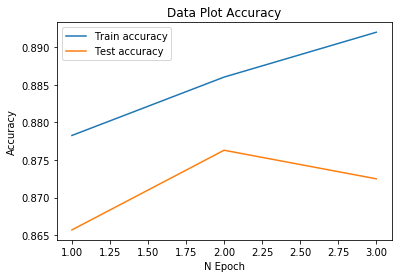

In [0]:
net = MLP().to(device);
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)

PATH = './MLP/MLP_3.pth'

checkpoint = torch.load(PATH)

net.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']

train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']

start_epoch = epoch + 1
nepochs = 6

run_training(net, criterion, optimizer, start_epoch, nepochs)


# LeNet

## Dataloading

In [0]:
batchSize = 64

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=0)

## LeNet Architecture

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        out = out.view(out.size(0), -1)
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        
        out = self.fc3(out)
        return out
      

print(LeNet())

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## LeNet with Sequential layer

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.view(out.size(0), -1)
        
        out = self.fc(out)
        return out
      

print(LeNet())

LeNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


## LeNet with DropOut

In [0]:
class LeNet(nn.Module):

    def __init__(self):
            super(LeNet, self).__init__()
            self.conv1 = nn.Conv2d(1, 6, 5)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.drop = nn.Dropout2d()
            self.fc1 = nn.Linear(4*4*16, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
            x = x.view(-1, 1, 28, 28)
            
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            x = x.view(x.size(0), -1) # Flatten the tensor
            
            x = F.relu(self.fc1(x))
            
            x = F.dropout(x, training=self.training)
            
            x = F.relu(self.fc2(x))
            x = F.dropout(x, training=self.training)
            x = F.log_softmax(self.fc3(x))
            
            return x
          
print(LeNet())

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [0]:
net = LeNet().to(device)

criterion = nn.CrossEntropyLoss();
#optimizer = torch.optim.Adam(net.parameters(), lr = 0.01);

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

start_epoch = 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)

Epoch: 1	 
          train loss: 0.563, train acc: 0.813	
          val loss: 0.418, val acc: 0.850	
          time: 11.5s Total time: 11.5s
Epoch: 2	 
          train loss: 0.366, train acc: 0.873	
          val loss: 0.369, val acc: 0.867	
          time: 11.6s Total time: 23.2s


KeyboardInterrupt: ignored

## Continue the Training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 41	 
          train loss: 0.369, train acc: 0.872	
          val loss: 0.332, val acc: 0.880	
          time: 11.1s Total time: 11.1s
Epoch: 42	 
          train loss: 0.363, train acc: 0.873	
          val loss: 0.331, val acc: 0.881	
          time: 11.2s Total time: 22.4s
Epoch: 43	 
          train loss: 0.362, train acc: 0.873	
          val loss: 0.327, val acc: 0.880	
          time: 11.2s Total time: 33.6s
Epoch: 44	 
          train loss: 0.358, train acc: 0.874	
          val loss: 0.331, val acc: 0.879	
          time: 11.3s Total time: 44.8s
Epoch: 45	 
          train loss: 0.354, train acc: 0.875	
          val loss: 0.327, val acc: 0.884	
          time: 11.1s Total time: 55.9s
Epoch: 46	 
          train loss: 0.351, train acc: 0.875	
          val loss: 0.324, val acc: 0.885	
          time: 11.4s Total time: 67.3s
Epoch: 47	 
          train loss: 0.352, train acc: 0.876	
          val loss: 0.326, val acc: 0.881	
          time: 11.2s Total time: 78.5s
Epoch:

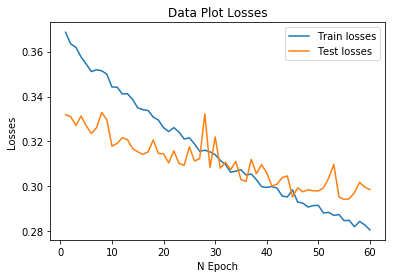

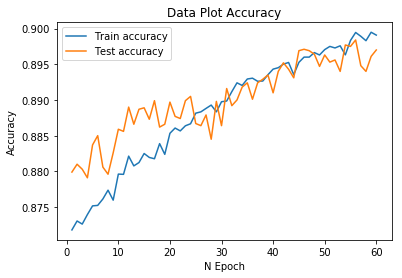

In [0]:
net = LeNet().to(device)
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

PATH = './LeNet/LeNet_40.pth'
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']

start_epoch = epoch + 1
nepochs = 100

run_training(net, criterion, optimizer, start_epoch, nepochs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 101	 
          train loss: 0.283, train acc: 0.900	
          val loss: 0.296, val acc: 0.897	
          time: 11.2s Total time: 11.2s
Epoch: 102	 
          train loss: 0.281, train acc: 0.900	
          val loss: 0.290, val acc: 0.899	
          time: 11.2s Total time: 22.4s
Epoch: 103	 
          train loss: 0.278, train acc: 0.901	
          val loss: 0.295, val acc: 0.899	
          time: 11.2s Total time: 33.6s
Epoch: 104	 
          train loss: 0.277, train acc: 0.902	
          val loss: 0.292, val acc: 0.898	
          time: 11.1s Total time: 44.7s
Epoch: 105	 
          train loss: 0.277, train acc: 0.902	
          val loss: 0.291, val acc: 0.897	
          time: 11.1s Total time: 55.7s
Epoch: 106	 
          train loss: 0.277, train acc: 0.902	
          val loss: 0.291, val acc: 0.900	
          time: 11.1s Total time: 66.8s
Epoch: 107	 
          train loss: 0.276, train acc: 0.903	
          val loss: 0.293, val acc: 0.897	
          time: 11.4s Total time: 78.2s

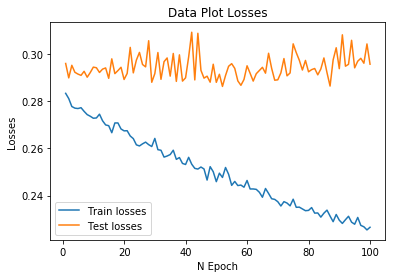

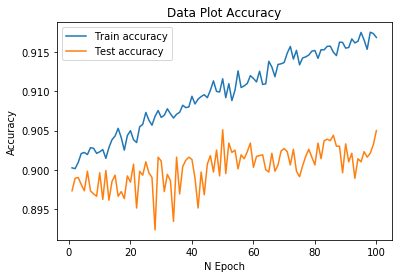

In [0]:
net = LeNet().to(device)
criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

PATH = './LeNet/LeNet_100.pth'
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']

start_epoch = epoch + 1
nepochs = 200

run_training(net, criterion, optimizer, start_epoch, nepochs)

# AlexNet

In [0]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=2)
        self.conv2 = nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.dense1 = nn.Linear(256*5*5,4096)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(4096,4096)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(4096,10)

    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        x=self.pool3(F.relu(self.conv5(F.relu(self.conv4(F.relu(self.conv3(x)))))))
        x=x.view(-1,256*5*5)
        x=self.dense3(self.drop2(F.relu(self.dense2(self.drop1(F.relu(self.dense1(x)))))))
        return x

In [0]:
batchSize = 64

transform = transforms.Compose([transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=0)

In [0]:
trainset, valset = torch.utils.data.random_split(trainset, [50000,10000])

In [0]:
len(trainset)

60000

In [0]:
net = AlexNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

start_epoch = 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)


Epoch: 1	 
          train loss: 0.832, train acc: 0.696	
          val loss: 0.403, val acc: 0.849	
          time: 94.6s Total time: 94.6s
Epoch: 2	 
          train loss: 0.359, train acc: 0.869	
          val loss: 0.333, val acc: 0.874	
          time: 95.1s Total time: 189.7s
Epoch: 3	 
          train loss: 0.295, train acc: 0.892	
          val loss: 0.335, val acc: 0.880	
          time: 94.9s Total time: 284.6s
Epoch: 4	 
          train loss: 0.255, train acc: 0.906	
          val loss: 0.257, val acc: 0.905	
          time: 95.3s Total time: 379.9s
Epoch: 5	 
          train loss: 0.231, train acc: 0.914	
          val loss: 0.260, val acc: 0.909	
          time: 95.1s Total time: 474.9s
Epoch: 6	 
          train loss: 0.209, train acc: 0.923	
          val loss: 0.246, val acc: 0.909	
          time: 95.3s Total time: 570.3s
Epoch: 7	 
          train loss: 0.188, train acc: 0.930	
          val loss: 0.243, val acc: 0.912	
          time: 95.3s Total time: 665.5s
Epoch:

KeyboardInterrupt: ignored

Epoch: 1	 
          train loss: 0.790, train acc: 0.709	
          val loss: 0.409, val acc: 0.848	
          time: 90.8s Total time: 90.8s
Epoch: 2	 
          train loss: 0.359, train acc: 0.867	
          val loss: 0.347, val acc: 0.871	
          time: 92.1s Total time: 182.9s
Epoch: 3	 
          train loss: 0.294, train acc: 0.892	
          val loss: 0.286, val acc: 0.896	
          time: 90.4s Total time: 273.3s
Epoch: 4	 
          train loss: 0.256, train acc: 0.906	
          val loss: 0.274, val acc: 0.896	
          time: 90.4s Total time: 363.7s
Epoch: 5	 
          train loss: 0.228, train acc: 0.916	
          val loss: 0.250, val acc: 0.908	
          time: 89.9s Total time: 453.6s
Epoch: 6	 
          train loss: 0.206, train acc: 0.923	
          val loss: 0.239, val acc: 0.914	
          time: 90.1s Total time: 543.8s
Epoch: 7	 
          train loss: 0.190, train acc: 0.930	
          val loss: 0.242, val acc: 0.912	
          time: 90.7s Total time: 634.4s
Epoch: 

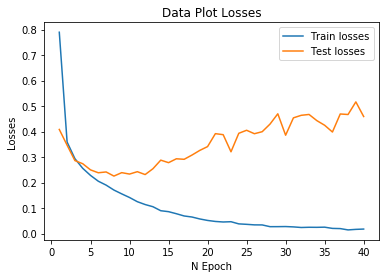

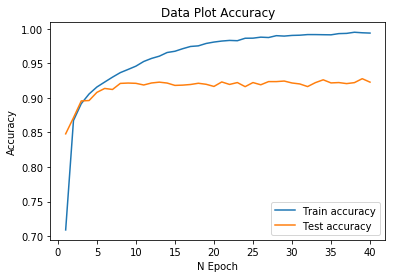

In [0]:
net = AlexNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

start_epoch = 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)

In [0]:
AlexNet

# VGG16


In [0]:
## MODELS

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import math
from torch.autograd import Variable


from torch.utils.model_zoo import load_url as load_state_dict_from_url

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## VGG

model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def vgg11(pretrained=False, progress=True, **kwargs):
    """VGG 11-layer model (configuration "A")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', False, pretrained, progress, **kwargs)


def vgg11_bn(pretrained=False, progress=True, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11_bn', 'A', True, pretrained, progress, **kwargs)


def vgg13(pretrained=False, progress=True, **kwargs):
    """VGG 13-layer model (configuration "B")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13', 'B', False, pretrained, progress, **kwargs)


def vgg13_bn(pretrained=False, progress=True, **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13_bn', 'B', True, pretrained, progress, **kwargs)


def vgg16(pretrained=False, progress=True, **kwargs):
    """VGG 16-layer model (configuration "D")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)


def vgg16_bn(pretrained=False, progress=True, **kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16_bn', 'D', True, pretrained, progress, **kwargs)


def vgg19(pretrained=False, progress=True, **kwargs):
    """VGG 19-layer model (configuration "E")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19', 'E', False, pretrained, progress, **kwargs)


def vgg19_bn(pretrained=False, progress=True, **kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19_bn', 'E', True, pretrained, progress, **kwargs)



In [0]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create dataloaders. Use pin memory if cuda.
nworkers = 4
batch_size = 256

trainset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                          shuffle=True, num_workers=nworkers)
testset = torchvision.datasets.FashionMNIST('data', train=False, transform=val_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                        shuffle=True, num_workers=nworkers)


In [0]:
from torchvision import models

net = models.vgg16(pretrained=True)

net.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
net.classifier[6] = nn.Linear(net.classifier[6].in_features, out_features=10, bias=True)

net = net.to(device)

In [0]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
net = vgg16(pretrained=False).to(device)

print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d


Epoch: 1	 
          train loss: 1.246, train acc: 0.471	
          val loss: 0.673, val acc: 0.748	
          time: 43.3s Total time: 43.3s
Epoch: 2	 
          train loss: 0.500, train acc: 0.821	
          val loss: 0.420, val acc: 0.858	
          time: 43.5s Total time: 86.8s
Epoch: 3	 
          train loss: 0.356, train acc: 0.876	
          val loss: 0.344, val acc: 0.882	
          time: 43.6s Total time: 130.4s
Epoch: 4	 
          train loss: 0.324, train acc: 0.889	
          val loss: 0.332, val acc: 0.883	
          time: 43.6s Total time: 174.0s
Epoch: 5	 
          train loss: 0.278, train acc: 0.904	
          val loss: 0.315, val acc: 0.893	
          time: 43.8s Total time: 217.7s
Epoch: 6	 
          train loss: 0.251, train acc: 0.914	
          val loss: 0.280, val acc: 0.904	
          time: 43.7s Total time: 261.4s
Epoch: 7	 
          train loss: 0.232, train acc: 0.922	
          val loss: 0.273, val acc: 0.907	
          time: 43.7s Total time: 305.1s
Epoch: 

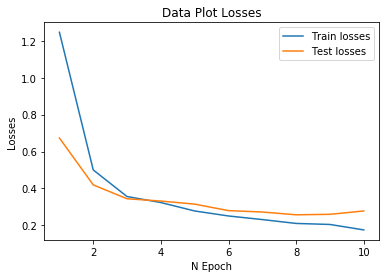

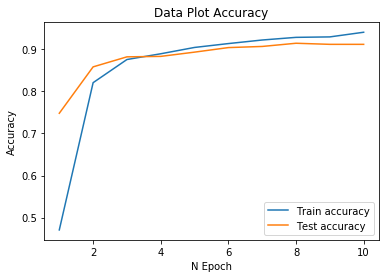

In [0]:
#net = vgg16(pretrained=False).to(device)

#net = models.vgg16(pretrained=False).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

start_epoch = 1
nepochs = 10

run_training(net, criterion, optimizer, start_epoch, nepochs)


Epoch: 1	 
          train loss: 0.976, train acc: 0.617	
          val loss: 0.482, val acc: 0.835	
          time: 41.4s Total time: 41.4s
Epoch: 2	 
          train loss: 0.419, train acc: 0.855	
          val loss: 0.350, val acc: 0.875	
          time: 42.2s Total time: 83.6s
Epoch: 3	 
          train loss: 0.321, train acc: 0.888	
          val loss: 0.324, val acc: 0.886	
          time: 42.8s Total time: 126.5s
Epoch: 4	 
          train loss: 0.365, train acc: 0.878	
          val loss: 0.719, val acc: 0.723	
          time: 43.1s Total time: 169.6s
Epoch: 5	 
          train loss: 0.343, train acc: 0.882	
          val loss: 0.284, val acc: 0.901	
          time: 43.4s Total time: 213.0s
Epoch: 6	 
          train loss: 0.242, train acc: 0.918	
          val loss: 0.252, val acc: 0.910	
          time: 43.6s Total time: 256.6s
Epoch: 7	 
          train loss: 0.216, train acc: 0.926	
          val loss: 0.279, val acc: 0.904	
          time: 43.6s Total time: 300.2s
Epoch: 

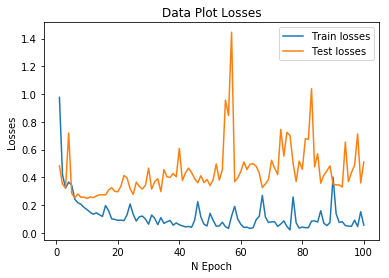

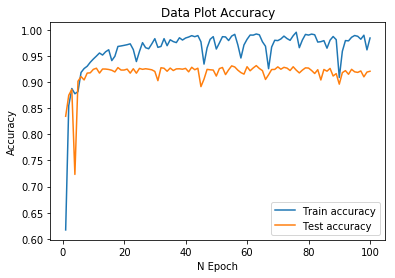

In [0]:
#net = vgg16(pretrained=False).to(device)

#net = models.vgg16(pretrained=False).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

start_epoch = 1
nepochs = 100

run_training(net, criterion, optimizer, start_epoch, nepochs)

## Continue Training...


Epoch: 101	 
          train loss: 0.031, train acc: 0.992	
          val loss: 0.538, val acc: 0.929	
          time: 43.6s Total time: 43.6s
Epoch: 102	 
          train loss: 0.072, train acc: 0.982	
          val loss: 0.427, val acc: 0.928	
          time: 44.8s Total time: 88.4s
Epoch: 103	 
          train loss: 0.104, train acc: 0.973	
          val loss: 0.377, val acc: 0.915	
          time: 44.1s Total time: 132.5s
Epoch: 104	 
          train loss: 0.045, train acc: 0.988	
          val loss: 0.521, val acc: 0.923	
          time: 44.3s Total time: 176.8s
Epoch: 105	 
          train loss: 0.029, train acc: 0.992	
          val loss: 0.612, val acc: 0.930	
          time: 44.1s Total time: 220.9s
Epoch: 106	 
          train loss: 0.049, train acc: 0.988	
          val loss: 0.488, val acc: 0.922	
          time: 44.2s Total time: 265.2s
Epoch: 107	 
          train loss: 0.067, train acc: 0.985	
          val loss: 0.598, val acc: 0.920	
          time: 44.2s Total time: 

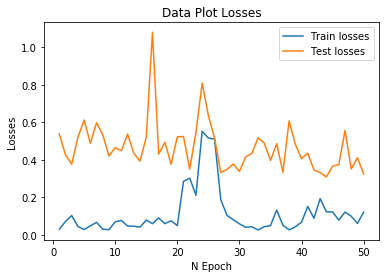

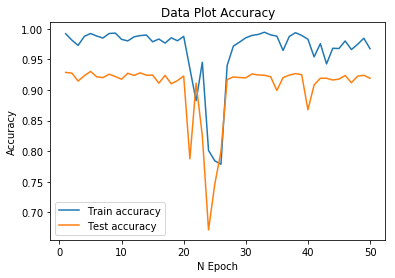

In [0]:
net = vgg16(pretrained=False).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

PATH = './VGG/VGG_100.pth'
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']

start_epoch = epoch + 1
nepochs = 150

run_training(net, criterion, optimizer, start_epoch, nepochs)


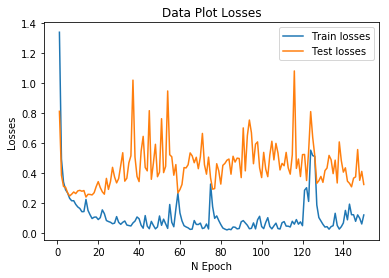

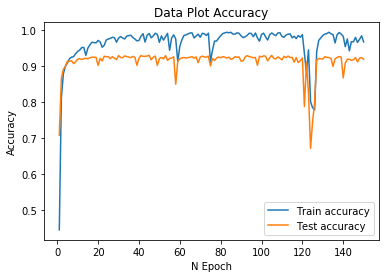

In [0]:
net = vgg16().to(device)

plot_based_model(net, 150)

# Plot Data based Model 

In [0]:
import matplotlib.ticker as mticker

def plot_based_model(net, n):
  # save weight per epoch
  
  model_str = net.__class__.__name__
  
  train_loss_list = []
  val_loss_list = []
  train_acc_list = []
  val_acc_list = []
  
  for e in range(1, n + 1):
    
    PATH = './' + model_str + '/'+ model_str +'_data_' + str(e) + '.pth'
    
    checkpoint = torch.load(PATH)

    train_loss_list.append(checkpoint['train_loss'])
    val_loss_list.append(checkpoint['val_loss'])
    train_acc_list.append(checkpoint['train_acc'])
    val_acc_list.append(checkpoint['val_acc'])
  
  nepoch_list = list(range(1, len(train_loss_list)+1))

  plt.figure()
  plt.xlabel('N Epoch')
  plt.title('Data Plot Losses')
  plt.ylabel('Losses')
  plt.ticklabel_format(style='plain', axis='x', useOffset=True)
  plt.plot(nepoch_list, train_loss_list,label = "Train losses")
  plt.plot(nepoch_list, val_loss_list, label = "Test losses")
  plt.legend()

  plt.figure()
  plt.xlabel('N Epoch')
  plt.title('Data Plot Accuracy')
  plt.ylabel('Accuracy')
  plt.ticklabel_format(style='plain', axis='x', useOffset=True)
  plt.plot(nepoch_list, train_acc_list, label = "Train accuracy")
  plt.plot(nepoch_list, val_acc_list, label = "Test accuracy")
  plt.legend()


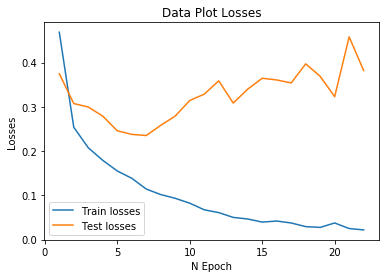

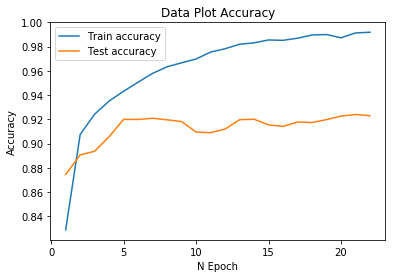

In [0]:
net = resnet50().to(device)

plot_based_model(net, 22)

# ResNet

## ResNet 18

In [0]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create dataloaders. Use pin memory if cuda.
nworkers = 4
batch_size = 256

trainset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                          shuffle=True, num_workers=nworkers)
testset = torchvision.datasets.FashionMNIST('data', train=False, transform=val_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                        shuffle=True, num_workers=nworkers)


In [0]:
import torch
from torchvision import datasets, models, transforms
import torch.optim as optim

import time
import argparse
import os

import torch
import torch.nn as nn
from PIL import Image, ImageOps
import numpy as np


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import math
from torch.autograd import Variable

from torch.utils.model_zoo import load_url as load_state_dict_from_url

from torch.utils import model_zoo

###############################################################################
#                                ResNet                                       #
###############################################################################

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

Epoch: 1	 
          train loss: 0.428, train acc: 0.845	
          val loss: 0.339, val acc: 0.884	
          time: 32.3s Total time: 32.3s
Epoch: 2	 
          train loss: 0.252, train acc: 0.909	
          val loss: 0.344, val acc: 0.872	
          time: 33.3s Total time: 65.6s
Epoch: 3	 
          train loss: 0.207, train acc: 0.925	
          val loss: 0.383, val acc: 0.865	
          time: 34.4s Total time: 100.0s
Epoch: 4	 
          train loss: 0.180, train acc: 0.934	
          val loss: 0.267, val acc: 0.902	
          time: 33.9s Total time: 134.0s
Epoch: 5	 
          train loss: 0.153, train acc: 0.944	
          val loss: 0.232, val acc: 0.916	
          time: 33.8s Total time: 167.8s
Epoch: 6	 
          train loss: 0.132, train acc: 0.952	
          val loss: 0.313, val acc: 0.897	
          time: 34.1s Total time: 202.0s
Epoch: 7	 
          train loss: 0.111, train acc: 0.961	
          val loss: 0.237, val acc: 0.922	
          time: 34.1s Total time: 236.1s
Epoch: 8

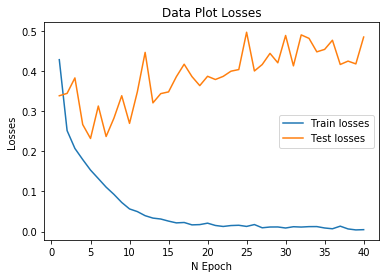

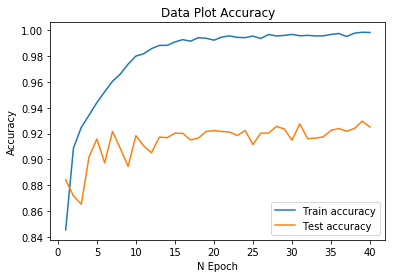

In [0]:
net = resnet18(pretrained=False).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

start_epoch = 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)

Continue the training...


Epoch: 41	 
          train loss: 0.014, train acc: 0.995	
          val loss: 0.424, val acc: 0.929	
          time: 33.7s Total time: 33.7s
Epoch: 42	 
          train loss: 0.007, train acc: 0.998	
          val loss: 0.460, val acc: 0.922	
          time: 34.4s Total time: 68.2s
Epoch: 43	 
          train loss: 0.012, train acc: 0.996	
          val loss: 0.457, val acc: 0.923	
          time: 33.8s Total time: 101.9s
Epoch: 44	 
          train loss: 0.011, train acc: 0.996	
          val loss: 0.482, val acc: 0.924	
          time: 33.9s Total time: 135.8s
Epoch: 45	 
          train loss: 0.010, train acc: 0.997	
          val loss: 0.445, val acc: 0.925	
          time: 34.1s Total time: 169.9s
Epoch: 46	 
          train loss: 0.005, train acc: 0.998	
          val loss: 0.448, val acc: 0.926	
          time: 33.9s Total time: 203.8s
Epoch: 47	 
          train loss: 0.002, train acc: 0.999	
          val loss: 0.436, val acc: 0.930	
          time: 33.8s Total time: 237.7s


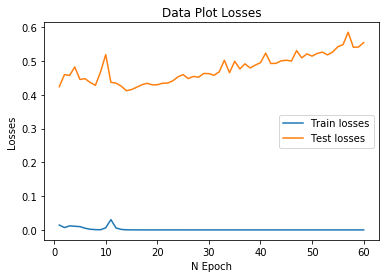

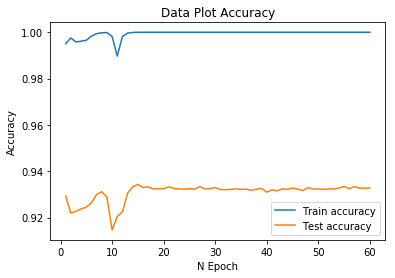

In [0]:
net = resnet18().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

PATH = './ResNet/ResNet_40.pth'
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']

start_epoch = epoch + 1
nepochs = 100

run_training(net, criterion, optimizer, start_epoch, nepochs)

Plot all graphics

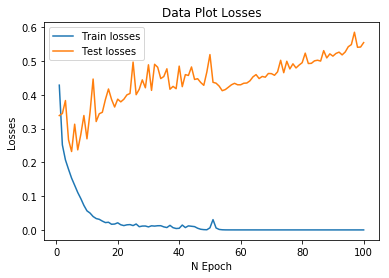

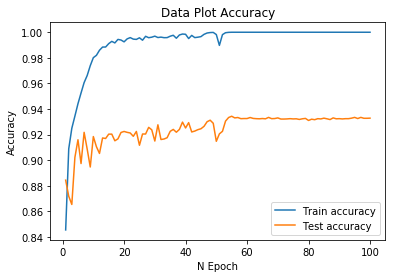

In [0]:
net = resnet18().to(device)

plot_based_model(net, 100)

## ResNet 50

Epoch: 1	 
          train loss: 0.464, train acc: 0.831	
          val loss: 0.400, val acc: 0.864	
          time: 132.6s Total time: 132.6s
Epoch: 2	 
          train loss: 0.253, train acc: 0.908	
          val loss: 0.419, val acc: 0.853	
          time: 133.6s Total time: 266.1s
Epoch: 3	 
          train loss: 0.208, train acc: 0.925	
          val loss: 0.273, val acc: 0.907	
          time: 133.6s Total time: 399.7s
Epoch: 4	 
          train loss: 0.179, train acc: 0.935	
          val loss: 0.247, val acc: 0.916	
          time: 133.9s Total time: 533.6s
Epoch: 5	 
          train loss: 0.154, train acc: 0.945	
          val loss: 0.247, val acc: 0.917	
          time: 133.7s Total time: 667.3s
Epoch: 6	 
          train loss: 0.137, train acc: 0.950	
          val loss: 0.281, val acc: 0.910	
          time: 133.8s Total time: 801.1s
Epoch: 7	 
          train loss: 0.120, train acc: 0.956	
          val loss: 0.248, val acc: 0.924	
          time: 133.9s Total time: 935.0s

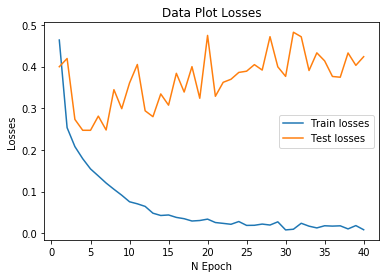

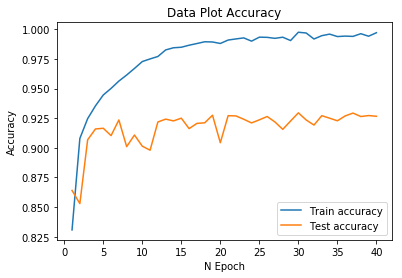

In [0]:
#from torchvision import models

net = resnet50(pretrained=False).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

start_epoch = 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)

### Contine Training ResNet 50...


Epoch: 23	 
          train loss: 0.024, train acc: 0.992	
          val loss: 0.413, val acc: 0.918	
          time: 125.1s Total time: 125.1s
Epoch: 24	 
          train loss: 0.027, train acc: 0.991	
          val loss: 0.401, val acc: 0.921	
          time: 136.6s Total time: 261.7s
Epoch: 25	 
          train loss: 0.018, train acc: 0.993	
          val loss: 0.424, val acc: 0.923	
          time: 141.2s Total time: 402.9s
Epoch: 26	 
          train loss: 0.020, train acc: 0.993	
          val loss: 0.517, val acc: 0.909	
          time: 142.4s Total time: 545.2s
Epoch: 27	 
          train loss: 0.023, train acc: 0.992	
          val loss: 0.466, val acc: 0.916	
          time: 143.0s Total time: 688.2s
Epoch: 28	 
          train loss: 0.019, train acc: 0.993	
          val loss: 0.390, val acc: 0.925	
          time: 144.1s Total time: 832.3s
Epoch: 29	 
          train loss: 0.013, train acc: 0.996	
          val loss: 0.446, val acc: 0.922	
          time: 144.0s Total time

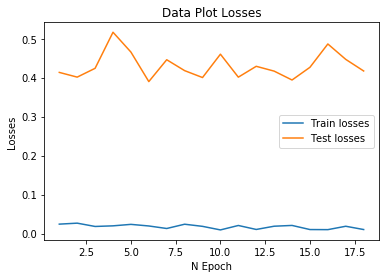

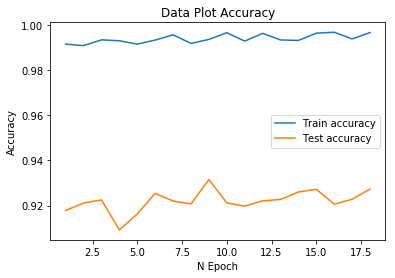

In [0]:
net = resnet50(pretrained = False).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

PATH = './ResNet/ResNet_22.pth'
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']

start_epoch = epoch + 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)

## ResNet 152




Epoch: 1	 
          train loss: 0.725, train acc: 0.784	
          val loss: 0.386, val acc: 0.858	
          time: 383.7s Total time: 383.7s
Epoch: 2	 
          train loss: 0.291, train acc: 0.894	
          val loss: 0.298, val acc: 0.891	
          time: 405.2s Total time: 788.9s
Epoch: 3	 
          train loss: 0.236, train acc: 0.913	
          val loss: 0.295, val acc: 0.898	
          time: 405.3s Total time: 1194.2s
Epoch: 4	 
          train loss: 0.274, train acc: 0.903	
          val loss: 0.282, val acc: 0.898	
          time: 406.7s Total time: 1600.9s
Epoch: 5	 
          train loss: 0.224, train acc: 0.919	
          val loss: 0.253, val acc: 0.905	
          time: 404.3s Total time: 2005.2s
Epoch: 6	 
          train loss: 0.234, train acc: 0.922	
          val loss: 0.536, val acc: 0.902	
          time: 404.4s Total time: 2409.6s
Epoch: 7	 
          train loss: 0.167, train acc: 0.940	
          val loss: 0.219, val acc: 0.923	
          time: 405.0s Total time: 2

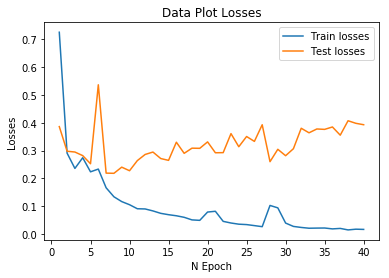

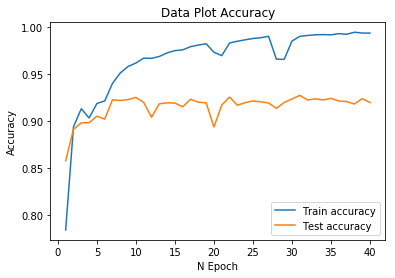

In [0]:
net = resnet152(pretrained=False).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

start_epoch = 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)

# Training the Data using GoogleNet


In [0]:
batchSize = 128
nworkers = 4

##load data
transform = transforms.Compose([transforms.Resize(96),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=nworkers)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=nworkers)

In [0]:
####network
def conv_relu(in_channels, out_channels, kernel, stride=1, padding=0):
    layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
        nn.BatchNorm2d(out_channels, eps=1e-3),
        nn.ReLU(True))
    return layer


class Inception(nn.Module):
    def __init__(self,in_channel,c1,c2,c3,c4):
        super(Inception,self).__init__()
        self.norm1_1=nn.BatchNorm2d(in_channel,eps=1e-3)
        self.p1_1=nn.Conv2d(in_channels=in_channel,out_channels=c1,kernel_size=1)
        self.norm2_1 = nn.BatchNorm2d(in_channel, eps=1e-3)
        self.p2_1=nn.Conv2d(in_channels=in_channel,out_channels=c2[0],kernel_size=1)
        self.norm2_2 = nn.BatchNorm2d(c2[0], eps=1e-3)
        self.p2_2=nn.Conv2d(in_channels=c2[0],out_channels=c2[1],kernel_size=3,padding=1)
        self.norm3_1 = nn.BatchNorm2d(in_channel, eps=1e-3)
        self.p3_1=nn.Conv2d(in_channels=in_channel,out_channels=c3[0],kernel_size=1)
        self.norm3_2 = nn.BatchNorm2d(c3[0], eps=1e-3)
        self.p3_2=nn.Conv2d(in_channels=c3[0],out_channels=c3[1],kernel_size=5,padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.norm4_2 = nn.BatchNorm2d(in_channel, eps=1e-3)
        self.p4_2 = nn.Conv2d(in_channels=in_channel, out_channels=c4, kernel_size=1)

    def forward(self, x):
        p1=self.p1_1(F.relu(self.norm1_1(x)))
        p2=self.p2_2(F.relu(self.norm2_2(self.p2_1(F.relu(self.norm2_1(x))))))
        p3=self.p3_2(F.relu(self.norm3_2(self.p3_1(F.relu(self.norm3_1(x))))))
        p4=self.p4_2(F.relu(self.norm4_2(self.p4_1(x))))
        return torch.cat((p1,p2,p3,p4),dim=1)

#Test Inception block
# test_net = Inception(3, 64, (48, 64), (64, 96), 32)
# test_x = Variable(torch.zeros(1, 3, 96, 96))
# print('input shape: {} x {} x {}'.format(test_x.shape[1], test_x.shape[2], test_x.shape[3]))
# test_y = test_net(test_x)
# print('output shape: {} x {} x {}'.format(test_y.shape[1], test_y.shape[2], test_y.shape[3]))


class GoogleNet(nn.Module):
    def __init__(self,in_channel,num_classes):
        super(GoogleNet,self).__init__()
        layers=[]
        layers+=[nn.Conv2d(in_channels=in_channel,out_channels=64,kernel_size=7,stride=2,padding=3),
                 nn.ReLU(),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]
        layers+=[nn.Conv2d(in_channels=64,out_channels=64,kernel_size=1),
                 nn.Conv2d(in_channels=64,out_channels=192,kernel_size=3,padding=1),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]
        layers+=[Inception(192,64,(96,128),(16,32),32),
                 Inception(256,128,(128,192),(32,96),64),
                 nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]
        layers+=[Inception(480, 192, (96, 208), (16, 48), 64),
                 Inception(512, 160, (112, 224), (24, 64), 64),
                 Inception(512, 128, (128, 256), (24, 64), 64),
                 Inception(512, 112, (144, 288), (32, 64), 64),
                 Inception(528, 256, (160, 320), (32, 128), 128),
               nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        layers += [Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AvgPool2d(kernel_size=2)]
        self.net = nn.Sequential(*layers)
        self.dense=nn.Linear(1024,num_classes)

    def forward(self,x):
        x=self.net(x)
        x=x.view(-1,1024*1*1)
        x=self.dense(x)
        return x


Epoch: 1	 
          train loss: 0.510, train acc: 0.814	
          val loss: 0.335, val acc: 0.872	
          time: 60.3s Total time: 60.3s
Epoch: 2	 
          train loss: 0.270, train acc: 0.900	
          val loss: 0.296, val acc: 0.890	
          time: 61.0s Total time: 121.3s
Epoch: 3	 
          train loss: 0.221, train acc: 0.918	
          val loss: 0.272, val acc: 0.903	
          time: 61.3s Total time: 182.6s
Epoch: 4	 
          train loss: 0.193, train acc: 0.929	
          val loss: 0.238, val acc: 0.916	
          time: 61.1s Total time: 243.6s
Epoch: 5	 
          train loss: 0.172, train acc: 0.935	
          val loss: 0.250, val acc: 0.911	
          time: 61.3s Total time: 304.9s
Epoch: 6	 
          train loss: 0.150, train acc: 0.944	
          val loss: 0.241, val acc: 0.918	
          time: 61.3s Total time: 366.2s
Epoch: 7	 
          train loss: 0.137, train acc: 0.949	
          val loss: 0.228, val acc: 0.922	
          time: 61.3s Total time: 427.5s
Epoch: 

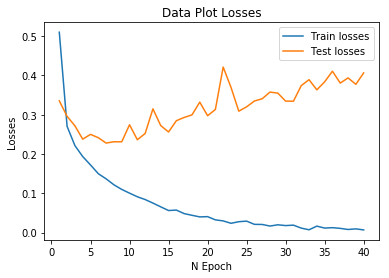

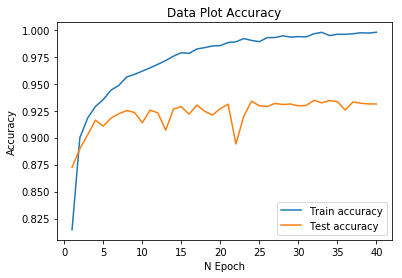

In [0]:
net = GoogleNet(1,10).cuda()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.9)

start_epoch = 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)


Continue the training...


Epoch: 41	 
          train loss: 0.007, train acc: 0.998	
          val loss: 0.391, val acc: 0.933	
          time: 61.5s Total time: 61.5s
Epoch: 42	 
          train loss: 0.003, train acc: 0.999	
          val loss: 0.395, val acc: 0.937	
          time: 61.0s Total time: 122.5s
Epoch: 43	 
          train loss: 0.002, train acc: 0.999	
          val loss: 0.420, val acc: 0.935	
          time: 61.3s Total time: 183.8s
Epoch: 44	 
          train loss: 0.005, train acc: 0.998	
          val loss: 0.433, val acc: 0.933	
          time: 60.9s Total time: 244.7s
Epoch: 45	 
          train loss: 0.009, train acc: 0.997	
          val loss: 0.444, val acc: 0.932	
          time: 61.1s Total time: 305.8s
Epoch: 46	 
          train loss: 0.008, train acc: 0.997	
          val loss: 0.406, val acc: 0.934	
          time: 61.0s Total time: 366.8s
Epoch: 47	 
          train loss: 0.006, train acc: 0.998	
          val loss: 0.423, val acc: 0.933	
          time: 61.1s Total time: 427.9s

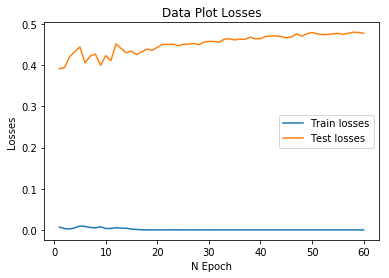

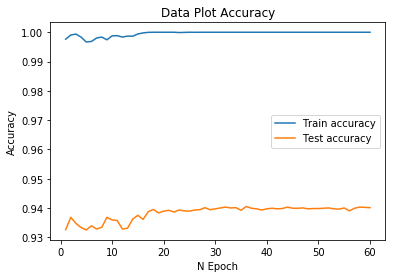

In [0]:
net = GoogleNet(1,10).cuda()
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)


PATH = './GoogleNet/GoogleNet_40.pth'
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']

start_epoch = epoch + 1
nepochs = 100

run_training(net, criterion, optimizer, start_epoch, nepochs)

Plot all data

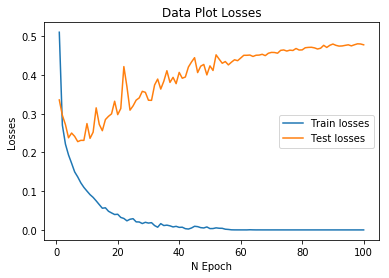

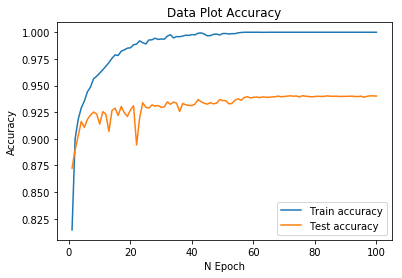

In [0]:
net = GoogleNet(1,10).cuda()

plot_based_model(net, 100)

# Training the Data using MobileNet

In [0]:
batchSize = 64
nworkers = 4

##load data
transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=nworkers)

testset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=nworkers)

In [0]:
class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  1,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        
        self.fc = nn.Linear(1024, 10)  #num of class

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

Epoch: 1	 
          train loss: 0.620, train acc: 0.775	
          val loss: 0.415, val acc: 0.842	
          time: 19.9s Total time: 19.9s
Epoch: 2	 
          train loss: 0.371, train acc: 0.865	
          val loss: 0.347, val acc: 0.868	
          time: 20.5s Total time: 40.5s
Epoch: 3	 
          train loss: 0.322, train acc: 0.882	
          val loss: 0.316, val acc: 0.882	
          time: 20.8s Total time: 61.2s
Epoch: 4	 
          train loss: 0.288, train acc: 0.894	
          val loss: 0.306, val acc: 0.886	
          time: 20.4s Total time: 81.7s
Epoch: 5	 
          train loss: 0.259, train acc: 0.904	
          val loss: 0.324, val acc: 0.879	
          time: 20.5s Total time: 102.2s
Epoch: 6	 
          train loss: 0.237, train acc: 0.913	
          val loss: 0.277, val acc: 0.896	
          time: 21.1s Total time: 123.3s
Epoch: 7	 
          train loss: 0.223, train acc: 0.918	
          val loss: 0.283, val acc: 0.898	
          time: 20.7s Total time: 144.1s
Epoch: 8	 

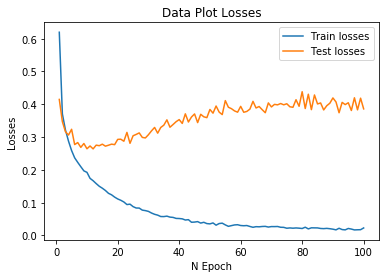

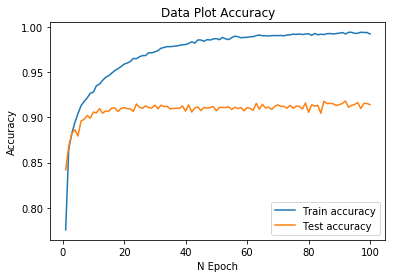

In [0]:
net = MobileNet().cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005,
                            momentum=0.9,
                            weight_decay=1e-4)

start_epoch = 1
nepochs = 100

run_training(net, criterion, optimizer, start_epoch, nepochs)

continue training...


Epoch: 41	 
          train loss: 0.058, train acc: 0.978	
          val loss: 0.356, val acc: 0.912	
          time: 24.0s Total time: 24.0s
Epoch: 42	 
          train loss: 0.058, train acc: 0.978	
          val loss: 0.354, val acc: 0.906	
          time: 25.0s Total time: 48.9s
Epoch: 43	 
          train loss: 0.061, train acc: 0.978	
          val loss: 0.339, val acc: 0.911	
          time: 24.8s Total time: 73.7s
Epoch: 44	 
          train loss: 0.056, train acc: 0.979	
          val loss: 0.340, val acc: 0.912	
          time: 25.0s Total time: 98.7s
Epoch: 45	 
          train loss: 0.057, train acc: 0.979	
          val loss: 0.349, val acc: 0.909	
          time: 24.4s Total time: 123.2s
Epoch: 46	 
          train loss: 0.058, train acc: 0.979	
          val loss: 0.319, val acc: 0.914	
          time: 24.1s Total time: 147.3s
Epoch: 47	 
          train loss: 0.053, train acc: 0.981	
          val loss: 0.333, val acc: 0.913	
          time: 24.2s Total time: 171.5s
Ep

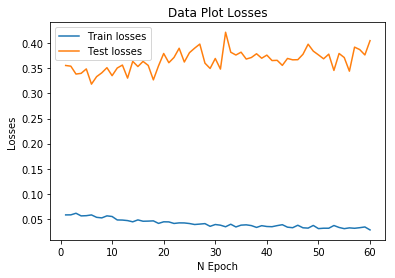

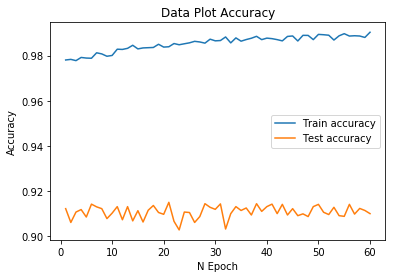

In [0]:
net = MobileNet().cuda()

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)


PATH = './MobileNet/MobileNet_40.pth'
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']

start_epoch = epoch + 1
nepochs = 100

run_training(net, criterion, optimizer, start_epoch, nepochs)

# Training Data using EffNet

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x
     
class EffNet(nn.Module):

    def __init__(self, nb_classes=10, include_top=True, weights=None):
        super(EffNet, self).__init__()
        
        self.block1 = self.make_layers(32, 64)
        self.block2 = self.make_layers(64, 128)
        self.block3 = self.make_layers(128, 256)
        self.flatten = Flatten()
        self.linear = nn.Linear(4096, nb_classes)
        self.include_top = include_top
        self.weights = weights

    def make_layers(self, ch_in, ch_out):
        layers = [
            nn.Conv2d(1, ch_in, kernel_size=(1,1), stride=(1,1), bias=False, padding=0, dilation=(1,1)) if ch_in ==32 else nn.Conv2d(ch_in, ch_in, kernel_size=(1,1),stride=(1,1), bias=False, padding=0, dilation=(1,1)) ,
            self.make_post(ch_in),
            # DepthWiseConvolution2D
            nn.Conv2d(ch_in, 1 * ch_in, groups=ch_in, kernel_size=(1, 3),stride=(1,1), padding=(0,1), bias=False, dilation=(1,1)),
            self.make_post(ch_in),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),
            # DepthWiseConvolution2D
            nn.Conv2d(ch_in, 1 * ch_in, groups=ch_in, kernel_size=(3, 1), stride=(1,1), padding=(1,0), bias=False, dilation=(1,1)),
            self.make_post(ch_in),
            nn.Conv2d(ch_in, ch_out, kernel_size=(1, 2), stride=(1, 2), bias=False, padding=(0,0), dilation=(1,1)),
            self.make_post(ch_out),
        ]
        return nn.Sequential(*layers)

    def make_post(self, ch_in):
        layers = [
            nn.LeakyReLU(0.3),
            nn.BatchNorm2d(ch_in, momentum=0.99)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        if self.include_top:
            x = self.flatten(x)
            x = self.linear(x)
        return x


Epoch: 1	 
          train loss: 0.406, train acc: 0.860	
          val loss: 0.337, val acc: 0.876	
          time: 16.9s Total time: 16.9s
Epoch: 2	 
          train loss: 0.275, train acc: 0.903	
          val loss: 0.283, val acc: 0.900	
          time: 17.9s Total time: 34.8s
Epoch: 3	 
          train loss: 0.234, train acc: 0.915	
          val loss: 0.267, val acc: 0.906	
          time: 18.1s Total time: 52.9s
Epoch: 4	 
          train loss: 0.205, train acc: 0.925	
          val loss: 0.274, val acc: 0.907	
          time: 17.9s Total time: 70.8s
Epoch: 5	 
          train loss: 0.186, train acc: 0.933	
          val loss: 0.258, val acc: 0.910	
          time: 17.8s Total time: 88.6s
Epoch: 6	 
          train loss: 0.171, train acc: 0.938	
          val loss: 0.257, val acc: 0.913	
          time: 17.3s Total time: 105.9s
Epoch: 7	 
          train loss: 0.156, train acc: 0.944	
          val loss: 0.276, val acc: 0.898	
          time: 17.3s Total time: 123.2s
Epoch: 8	 

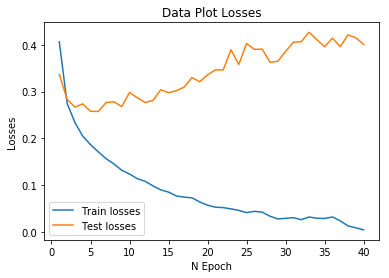

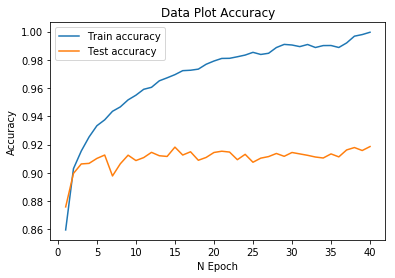

In [0]:
net = EffNet().cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01,
                            momentum=0.9,
                            weight_decay=1e-4)

start_epoch = 1
nepochs = 40

run_training(net, criterion, optimizer, start_epoch, nepochs)


Epoch: 41	 
          train loss: 0.002, train acc: 1.000	
          val loss: 0.399, val acc: 0.922	
          time: 17.1s Total time: 17.1s
Epoch: 42	 
          train loss: 0.001, train acc: 1.000	
          val loss: 0.404, val acc: 0.924	
          time: 18.4s Total time: 35.5s
Epoch: 43	 
          train loss: 0.001, train acc: 1.000	
          val loss: 0.402, val acc: 0.922	
          time: 17.9s Total time: 53.4s
Epoch: 44	 
          train loss: 0.001, train acc: 1.000	
          val loss: 0.415, val acc: 0.923	
          time: 17.7s Total time: 71.0s
Epoch: 45	 
          train loss: 0.001, train acc: 1.000	
          val loss: 0.399, val acc: 0.923	
          time: 17.6s Total time: 88.6s
Epoch: 46	 
          train loss: 0.001, train acc: 1.000	
          val loss: 0.390, val acc: 0.922	
          time: 17.6s Total time: 106.2s
Epoch: 47	 
          train loss: 0.001, train acc: 1.000	
          val loss: 0.407, val acc: 0.921	
          time: 17.7s Total time: 123.9s
Epo

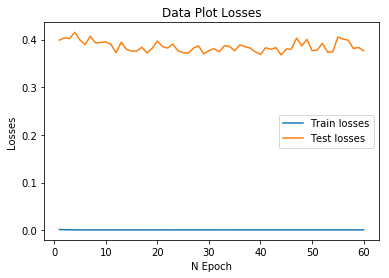

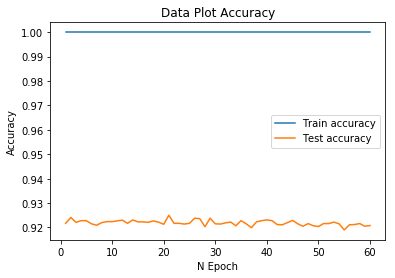

In [0]:
net = EffNet().cuda()

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)


PATH = './EffNet/EffNet_40.pth'
checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
train_acc = checkpoint['train_acc']

start_epoch = epoch + 1
nepochs = 100

run_training(net, criterion, optimizer, start_epoch, nepochs)

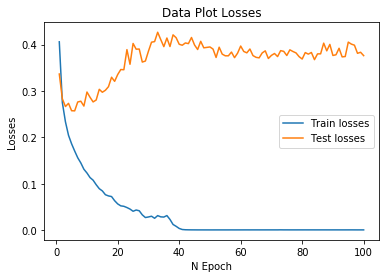

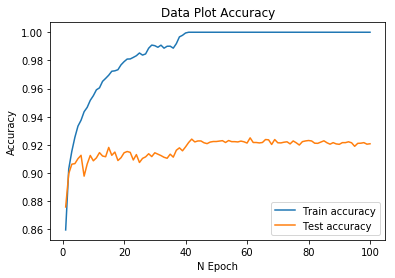

In [0]:
net = EffNet().cuda()

plot_based_model(net, 100)

# Others

## Download files from server storage

In [0]:
from google.colab import files
files.download("./ResNet/ResNet_22.pth")


In [0]:
import os

print("File in MB")

print(os.path.getsize("./MLP/MLP_1.pth")/1e6)

print(os.path.getsize("./LeNet/LeNet_1.pth")/1e6)

print(os.path.getsize("./VGG/VGG_1.pth")/1e6)

print(os.path.getsize("./ResNet18/ResNet_1.pth")/1e6)

print(os.path.getsize("./ResNet/ResNet_1.pth")/1e6)

File in MB
1.944847
0.118982
1660.292553
33.365711
102.742009


In [0]:
import os

print(os.path.getsize("./GoogleNet/GoogleNet_1.pth")/1e6)

print(os.path.getsize("./MobileNet/MobileNet_1.pth")/1e6)

48.400654
25.861361


## Rename files or folder

In [0]:
!mv ResNet ResNet18

## Connect to Google Drive storage

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls

data  EffNet  GoogleNet  MobileNet  ResNet  ResNet18  sample_data


In [0]:
!ls 'gdrive/My Drive/colab_project'

dataset  model	model.pt


In [0]:
!cp ResNet/ResNet_40.pth  'gdrive/My Drive/colab_project/model'

In [0]:
!cp VGG/VGG_40.pth  'gdrive/My Drive/colab_project/model'

In [0]:
!mkdir ResNet

In [0]:
!cp 'gdrive/My Drive/colab_project/model/ResNet_22.pth'  ResNet/ResNet_22.pth

In [0]:
!ls ResNet

ResNet_10.pth  ResNet_29.pth  ResNet_data_10.pth  ResNet_data_29.pth
ResNet_11.pth  ResNet_2.pth   ResNet_data_11.pth  ResNet_data_2.pth
ResNet_12.pth  ResNet_30.pth  ResNet_data_12.pth  ResNet_data_30.pth
ResNet_13.pth  ResNet_31.pth  ResNet_data_13.pth  ResNet_data_31.pth
ResNet_14.pth  ResNet_32.pth  ResNet_data_14.pth  ResNet_data_32.pth
ResNet_15.pth  ResNet_33.pth  ResNet_data_15.pth  ResNet_data_33.pth
ResNet_16.pth  ResNet_34.pth  ResNet_data_16.pth  ResNet_data_34.pth
ResNet_17.pth  ResNet_35.pth  ResNet_data_17.pth  ResNet_data_35.pth
ResNet_18.pth  ResNet_36.pth  ResNet_data_18.pth  ResNet_data_36.pth
ResNet_19.pth  ResNet_37.pth  ResNet_data_19.pth  ResNet_data_37.pth
ResNet_1.pth   ResNet_38.pth  ResNet_data_1.pth   ResNet_data_38.pth
ResNet_20.pth  ResNet_39.pth  ResNet_data_20.pth  ResNet_data_39.pth
ResNet_21.pth  ResNet_3.pth   ResNet_data_21.pth  ResNet_data_3.pth
ResNet_22.pth  ResNet_40.pth  ResNet_data_22.pth  ResNet_data_40.pth
ResNet_23.pth  ResNet_4.pth   ResNet

In [0]:
!cp ResNet/ResNet_40.pth  'gdrive/My Drive/colab_project/model'

In [0]:
!cd /content